In [ ]:
!pip install requests pandas yfinance python-dateutil tqdm copulas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 2.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ============================================
# CAPSTONE PROJECT: SEC FILINGS + PRICE DATA
# ============================================

import pandas as pd
import json
import requests
import time
import yfinance as yf
from pathlib import Path
from typing import List, Dict

# ------------------------------
# CONFIG
# ------------------------------
SEC_HEADERS = {"User-Agent": "aezhil@umich.edu"}
REQUEST_SLEEP = 0.2
SEC_BASE = "https://data.sec.gov"
DATA_DIR = Path("/content/drive/MyDrive/SEC_DATA")
DATA_DIR.mkdir(parents=True, exist_ok=True)

# JSON files you downloaded manually
JSON_PATHS = {
    "NVDA": "/content/drive/MyDrive/SEC/NVDA_filings.json",
    "TSM": "/content/drive/MyDrive/SEC/TSM_filings.json"
}

In [ ]:
# ------------------------------
# Parse submissions JSON
# ------------------------------
def parse_submissions_json(json_path: str, forms: List[str], limit_per_form: int = 10) -> pd.DataFrame:
    """
    Parse local SEC submissions JSON and extract metadata for recent filings.
    """
    print(f"Parsing {json_path} ...")
    with open(json_path, "r") as f:
        js = json.load(f)

    recent = js.get("filings", {}).get("recent", {})
    if not recent:
        return pd.DataFrame()

    df = pd.DataFrame(recent)
    print(f"Found {len(df)} filings in {json_path}")
    df = df[["accessionNumber", "filingDate", "reportDate", "form", "primaryDocument"]]
    df = df[df["form"].isin(forms)].copy()

    rows = []
    for ftype in forms:
        sub = df[df["form"] == ftype].sort_values("filingDate", ascending=False)
        rows.append(sub)
    out = pd.concat(rows).sort_values(["filingDate", "form"], ascending=False).reset_index(drop=True)
    out["json_path"] = json_path
    print(f"Returning {len(out)} filings for {', '.join(forms)}")
    return out

def parse_submissions_json_all(json_path: str, forms: List[str], start_year: int = 2020) -> pd.DataFrame:
    """
    Parse local SEC submissions JSON and extract filings from a specified start year to latest.
    """
    with open(json_path, "r") as f:
        js = json.load(f)

    all_filings = []

    # The 'filings' -> 'files' section holds paths for yearly filing data
    yearly_files = js.get("filings", {}).get("files", [])
    for file_meta in yearly_files:
        if "filing" in file_meta["name"] and int(file_meta["name"].split("-")[1].split(".")[0]) >= start_year:
            # load each year's filing json (they must be downloaded or exist locally)
            year_path = json_path.replace("submissions", file_meta["name"])
            try:
                with open(year_path, "r") as yf:
                    yj = json.load(yf)
                    df_year = pd.DataFrame(yj.get("filings", []))
                    all_filings.append(df_year)
            except FileNotFoundError:
                print(f"⚠️ Missing yearly file: {year_path}")

    if not all_filings:
        print("No filings found for the given range.")
        return pd.DataFrame()

    df = pd.concat(all_filings, ignore_index=True)
    df = df[["accessionNumber", "filingDate", "reportDate", "form", "primaryDocument"]]
    df = df[df["form"].isin(forms)]
    df["json_path"] = json_path
    df = df.sort_values("filingDate", ascending=False).reset_index(drop=True)

    return df


# ------------------------------
# Build SEC URLs and download filings
# ------------------------------
def build_filing_url(cik: str, accession_number: str, primary_document: str) -> str:
    """
    Construct the URL for the primary filing document.
    """
    cik_int = str(int(cik))
    acc_path = accession_number.replace("-", "")
    return f"https://www.sec.gov/Archives/edgar/data/{cik_int}/{acc_path}/{primary_document}"


def download_filing_document(cik: str, accession_number: str, primary_document: str, out_dir: Path) -> Path:
    """
    Download a filing document (HTML/TXT) from the SEC EDGAR archive.
    """
    url = build_filing_url(cik, accession_number, primary_document)
    out_dir.mkdir(parents=True, exist_ok=True)
    fname = f"{accession_number}_{primary_document}".replace("/", "_")
    fpath = out_dir / fname

    try:
        r = requests.get(url, headers=SEC_HEADERS, timeout=60)
        time.sleep(REQUEST_SLEEP)
        if r.status_code != 200:
            raise Exception(f"Bad status: {r.status_code}")
        fpath.write_bytes(r.content)
        return fpath
    except Exception as e:
        print(f"Failed to fetch {url}: {e}")
        return None


# ------------------------------
# Yahoo Finance Price Data
# ------------------------------
def fetch_prices(symbols, start="2020-01-01", end=None):
    """
    Download adjusted close prices for one or more tickers and return a tidy DataFrame.
    """
    data = yf.download(symbols, start=start, end=end, progress=False, auto_adjust=True)

    # Handle multi or single ticker cases
    if isinstance(data.columns, pd.MultiIndex):
        # multi-ticker case (data has e.g. ('Open','NVDA'), ('Close','NVDA'), ...)
        px = data["Close"].copy()
    else:
        # single-ticker case
        px = data.rename(columns={"Close": symbols if isinstance(symbols, str) else symbols[0]})

    return px


In [ ]:

# ------------------------------
# MAIN RUNNER
# ------------------------------
def main(forms=["10-K", "10-Q", "8-K"], limit_per_form=5):
    all_filings = []

    for ticker, path in JSON_PATHS.items():
        print(f"\nProcessing filings for {ticker} ...")
        df = parse_submissions_json(path, forms=forms, limit_per_form=limit_per_form)
        # df = parse_submissions_json_all("/content/drive/MyDrive/SEC/NVDA_submissions.json", forms)

        df["ticker"] = ticker
        all_filings.append(df)

    filings_df = pd.concat(all_filings).reset_index(drop=True)

    # Save filings metadata
    filings_csv = DATA_DIR / "filings_metadata_TSM.csv"
    filings_df.to_csv(filings_csv, index=False)
    print(f"✅ Filings metadata saved to {filings_csv}")

    # Download documents (optional)
    for _, row in filings_df.iterrows():
        out_dir = DATA_DIR / "filings" / row["ticker"]
        cik_guess = "1045810" if row["ticker"] == "NVDA" else "1046179"  # rough mapping for demo
        _ = download_filing_document(cik_guess, row["accessionNumber"], row["primaryDocument"], out_dir)

    # Fetch price data
    price_symbols = ["NVDA", "TSM", "QQQ", "XLK"]
    prices_df = fetch_prices(price_symbols, start="2018-01-01")
    price_csv = DATA_DIR / "price_data.csv"
    prices_df.to_csv(price_csv)
    print(f"✅ Price data saved to {price_csv}")

    return filings_df, prices_df


# ------------------------------
# RUN MAIN
# ------------------------------
if __name__ == "__main__":
    filings_df, prices_df = main()
    display(filings_df.head())
    display(prices_df.tail())



Processing filings for NVDA ...
Parsing /content/drive/MyDrive/SEC/NVDA_filings.json ...
Found 1000 filings in /content/drive/MyDrive/SEC/NVDA_filings.json
Returning 92 filings for 10-K, 10-Q, 8-K

Processing filings for TSM ...
Parsing /content/drive/MyDrive/SEC/TSM_filings.json ...
Found 1000 filings in /content/drive/MyDrive/SEC/TSM_filings.json
Returning 0 filings for 10-K, 10-Q, 8-K
✅ Filings metadata saved to /content/drive/MyDrive/SEC_DATA/filings_metadata_TSM.csv


KeyboardInterrupt: 

In [ ]:
display(filings_df.head())


,accessionNumber,filingDate,reportDate,form,primaryDocument,json_path,ticker
0,0001045810-25-000207,2025-08-27,2025-08-27,8-K,nvda-20250827.htm,/content/drive/MyDrive/SEC/NVDA_filings.json,NVDA
1,0001045810-25-000209,2025-08-27,2025-07-27,10-Q,nvda-20250727.htm,/content/drive/MyDrive/SEC/NVDA_filings.json,NVDA
2,0001045810-25-000197,2025-08-05,2025-07-31,8-K,nvda-20250731.htm,/content/drive/MyDrive/SEC/NVDA_filings.json,NVDA
3,0001045810-25-000179,2025-07-01,2025-06-25,8-K,nvda-20250625.htm,/content/drive/MyDrive/SEC/NVDA_filings.json,NVDA
4,0001045810-25-000115,2025-05-28,2025-05-28,8-K,nvda-20250528.htm,/content/drive/MyDrive/SEC/NVDA_filings.json,NVDA


✅ Data Loaded:
                NVDA         QQQ        TSM        XLK
Date                                                  
2018-01-02  4.928807  150.605362  34.046806  59.910858
2018-01-03  5.253191  152.068726  34.619488  60.410587
2018-01-04  5.280882  152.334808  34.436897  60.715977
2018-01-05  5.325634  153.864777  35.241997  61.354504
2018-01-08  5.488817  154.463379  35.225399  61.585865 

Filings Count: 92


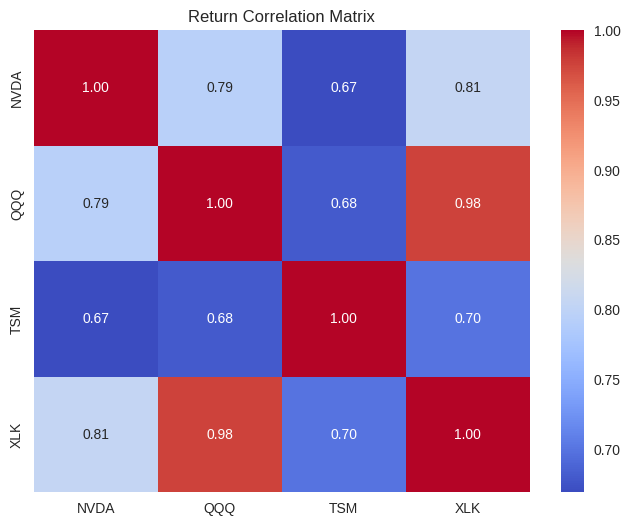

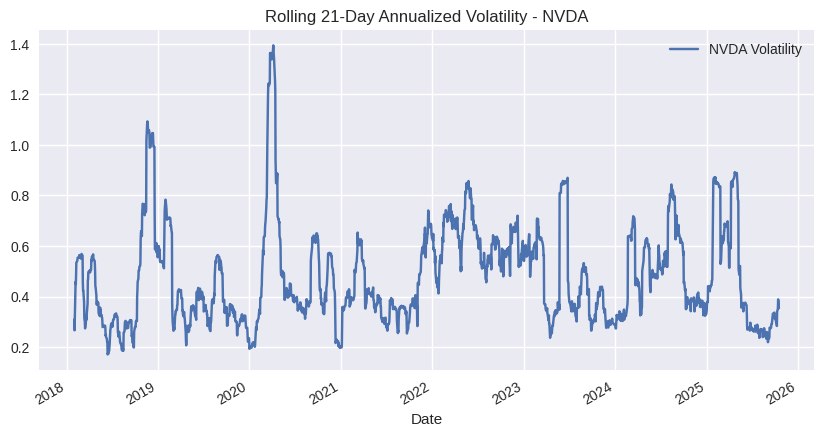

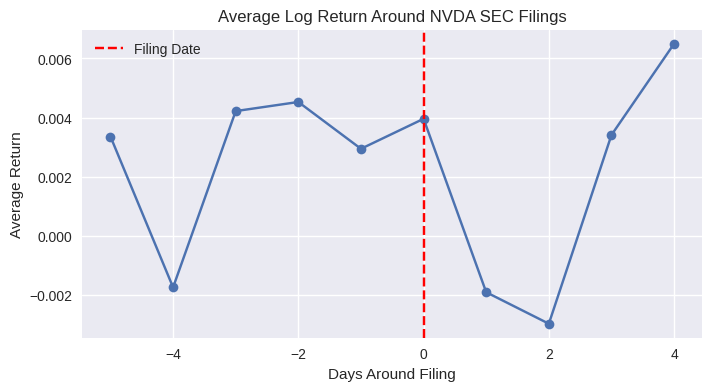

/usr/local/lib/python3.12/dist-packages/scipy/stats/_continuous_distns.py:796: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_continuous_distns.py:801: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
/usr/local/lib/python3.12/dist-packages/scipy/stats/_continuous_distns.py:801: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


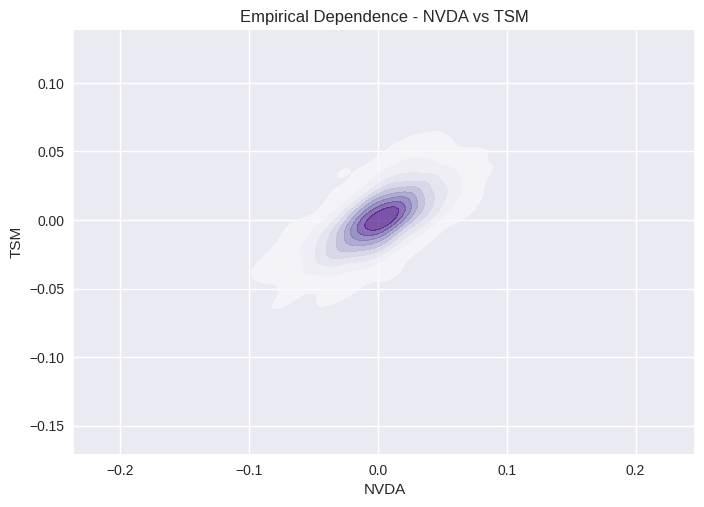

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


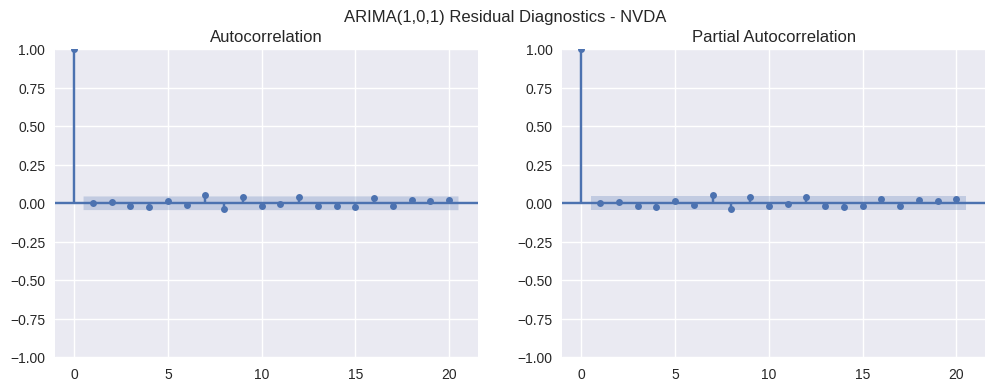

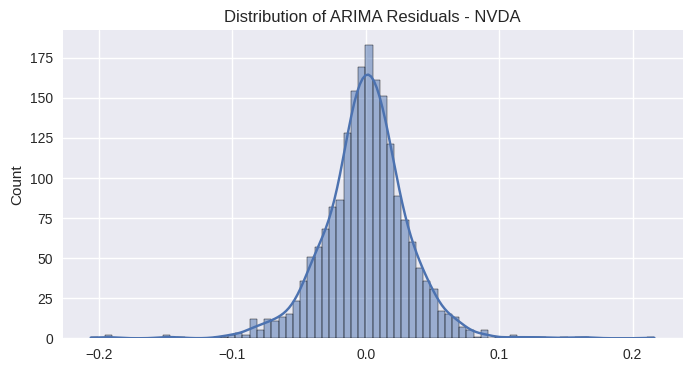

In [ ]:
# ============================================
# 📦 Setup
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import timedelta
from copulas.multivariate import GaussianMultivariate

plt.style.use("seaborn-v0_8")

# --------------------------------------------
# 1️⃣ Load Data
# --------------------------------------------
price_df = pd.read_csv("/content/drive/MyDrive/SEC_DATA/price_data.csv", parse_dates=["Date"])
price_df = price_df.set_index("Date").sort_index()

filings_df = pd.read_csv("/content/drive/MyDrive/SEC_DATA/filings_metadata.csv", parse_dates=["filingDate"])
filings_df = filings_df[filings_df["form"].isin(["10-K", "10-Q", "8-K"])]

print("✅ Data Loaded:")
print(price_df.head(), "\n")
print(f"Filings Count: {len(filings_df)}")

# --------------------------------------------
# 2️⃣ Compute Log Returns and Rolling Volatility
# --------------------------------------------
returns = np.log(price_df / price_df.shift(1)).dropna()
rolling_vol = returns.rolling(21).std() * np.sqrt(252)

# Correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(returns.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Return Correlation Matrix")
plt.savefig("return_correlation.png")
plt.show()


# Volatility over time
plt.figure(figsize=(10, 5))
rolling_vol["NVDA"].plot(label="NVDA Volatility")
plt.title("Rolling 21-Day Annualized Volatility - NVDA")
plt.legend()
plt.savefig("volatility.png")
plt.show()

# --------------------------------------------
# 3️⃣ Event Study - SEC Filings
# --------------------------------------------
event_window = 5  # ±5 days
nvda_events = filings_df[filings_df["ticker"] == "NVDA"]["filingDate"]

def event_study(event_dates, prices, window=5):
    """
    Compute average log returns around event dates.
    Handles missing dates and variable-length windows safely.
    """
    aligned_returns = []

    for d in event_dates:
        if d not in prices.index:
            continue
        # slice ±window trading days, not calendar days
        loc = prices.index.get_loc(d)
        start = max(0, loc - window)
        end = min(len(prices) - 1, loc + window)
        window_slice = prices.iloc[start:end+1]
        if len(window_slice) < 2:
            continue
        log_ret = np.log(window_slice / window_slice.shift(1)).dropna().values.flatten()
        aligned_returns.append(log_ret)

    # Pad each array to the same length with NaN, then mean ignoring NaN
    max_len = max(map(len, aligned_returns))
    padded = np.full((len(aligned_returns), max_len), np.nan)
    for i, arr in enumerate(aligned_returns):
        padded[i, :len(arr)] = arr

    avg_ret = np.nanmean(padded, axis=0)
    return avg_ret


avg_ret = event_study(nvda_events, price_df["NVDA"], event_window)

plt.figure(figsize=(8, 4))
if avg_ret is not None:
    plt.plot(range(-event_window, event_window), avg_ret[-2*event_window:], marker="o")
    plt.axvline(0, color="red", linestyle="--", label="Filing Date")
    plt.title("Average Log Return Around NVDA SEC Filings")
    plt.xlabel("Days Around Filing")
    plt.ylabel("Average Return")
    plt.legend()
    plt.grid(True)
plt.savefig("event_study.png")
plt.show()


# --------------------------------------------
# 4️⃣ Dependence Structure (Copula)
# --------------------------------------------
copula_data = returns[["NVDA", "TSM"]].dropna()
copula = GaussianMultivariate()
copula.fit(copula_data)
samples = copula.sample(1000)

sns.kdeplot(x="NVDA", y="TSM", data=copula_data, fill=True, cmap="Purples", alpha=0.7)
plt.title("Empirical Dependence - NVDA vs TSM")
plt.savefig("empirical_dependence.png")
plt.show()

# --------------------------------------------
# 5️⃣ ARIMA Residual Analysis - NVDA
# --------------------------------------------
model = sm.tsa.ARIMA(returns["NVDA"], order=(1,0,1)).fit()
resid = model.resid

fig, ax = plt.subplots(1,2,figsize=(12,4))
sm.graphics.tsa.plot_acf(resid, ax=ax[0], lags=20)
sm.graphics.tsa.plot_pacf(resid, ax=ax[1], lags=20)
plt.suptitle("ARIMA(1,0,1) Residual Diagnostics - NVDA")
plt.savefig("arima_residuals.png")
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(resid, kde=True)
plt.title("Distribution of ARIMA Residuals - NVDA")
plt.savefig("arima_residual_hist.png")
plt.show()

In [ ]:
%pip install copulas

100%|██████████| 92/92 [01:38<00:00,  1.07s/it]

✅ Parsed Filings:


,filename,filing_date,polarity,subjectivity
31,0001045810-20-000065_nvda-20200426.htm,2020-04-26,0.042881,0.338699
30,0001045810-20-000063_nvda-20200521.htm,2020-05-21,-0.033174,0.276555
28,0001045810-20-000127_nvda-20200713.htm,2020-07-13,-0.053725,0.386079
27,0001045810-20-000147_nvda-20200726.htm,2020-07-26,0.043444,0.326707
26,0001045810-20-000145_nvda-20200819.htm,2020-08-19,-0.033174,0.276555


✅ Merged dataset:


,filing_date,polarity,subjectivity,NVDA
0,2020-04-26,0.042881,0.338699,0.025535
1,2020-05-21,-0.033174,0.276555,-0.021950
2,2020-07-13,-0.053725,0.386079,-0.041601
3,2020-07-26,0.043444,0.326707,0.022023
4,2020-08-19,-0.033174,0.276555,-0.010021


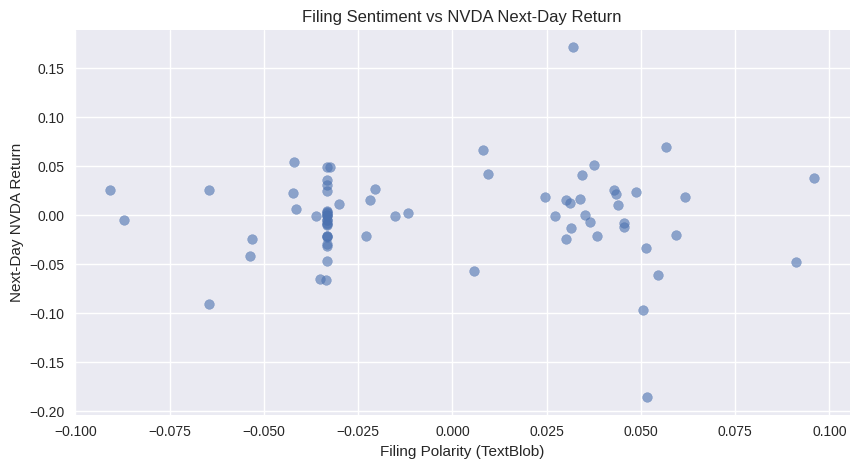

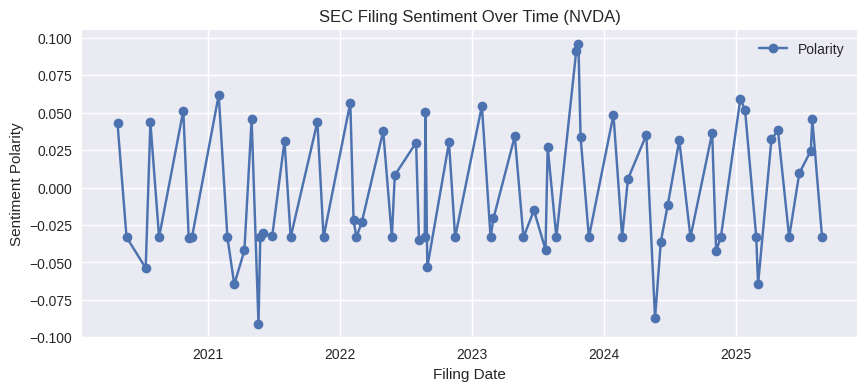

In [ ]:
# ============================================
# 📦 Setup
# ============================================
import os
import re
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from textblob import TextBlob
from tqdm import tqdm
import matplotlib.pyplot as plt

base_path = "/content/drive/MyDrive/SEC_DATA/filings/NVDA"

# ============================================
# 🧠 1️⃣ Parse and Extract Filing Text
# ============================================
def clean_html(file_path):
    """Extract and clean visible text from SEC filing HTML."""
    with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
        html = f.read()
    soup = BeautifulSoup(html, "html.parser")

    # Remove tables, scripts, and styles
    for tag in soup(["table", "script", "style"]):
        tag.decompose()

    text = soup.get_text(separator=" ")
    text = re.sub(r"\s+", " ", text).strip()
    return text.lower()

# Collect text and sentiment
records = []
c=0
for fname in tqdm(os.listdir(base_path)):
    if not fname.endswith(".htm"):
        continue
    file_path = os.path.join(base_path, fname)
    text = clean_html(file_path)

    # Simple TextBlob sentiment
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity

    # Extract filing date from filename (e.g., nvda-20210131.htm)
    match = re.search(r"(\d{8})(?=\.\w+$)", fname)
    if match:
        filing_date = pd.to_datetime(match.group(1), format="%Y%m%d", errors="coerce")
    else:
        filing_date = None


    records.append({
        "filename": fname,
        "filing_date": filing_date,
        "polarity": polarity,
        "subjectivity": subjectivity,
        "char_length": len(text),
        "text": text[:2000]  # preview only (optional)
    })

sec_sent = pd.DataFrame(records)
sec_sent = sec_sent.sort_values("filing_date").dropna(subset=["filing_date"])

print("✅ Parsed Filings:")
display(sec_sent[["filename", "filing_date", "polarity", "subjectivity"]].head())

# ============================================
# 📈 2️⃣ Merge Sentiment with Prices
# ============================================
price_df = pd.read_csv("/content/drive/MyDrive/SEC_DATA/price_data.csv", parse_dates=["Date"]).set_index("Date")
returns = np.log(price_df / price_df.shift(1)).dropna()

# Merge by nearest date (since filings might be non-trading days)
merged = pd.merge_asof(sec_sent.sort_values("filing_date"),
                       returns.reset_index().sort_values("Date"),
                       left_on="filing_date",
                       right_on="Date",
                       direction="forward")

print("✅ Merged dataset:")
display(merged[["filing_date", "polarity", "subjectivity", "NVDA"]].head())

# ============================================
# 📊 3️⃣ Visualize Sentiment vs NVDA Returns
# ============================================
plt.figure(figsize=(10,5))
plt.scatter(merged["polarity"], merged["NVDA"], alpha=0.6)
plt.title("Filing Sentiment vs NVDA Next-Day Return")
plt.xlabel("Filing Polarity (TextBlob)")
plt.ylabel("Next-Day NVDA Return")
plt.grid(True)
plt.savefig("sentiment_returns.png")
plt.show()

# Rolling sentiment over time
plt.figure(figsize=(10,4))
plt.plot(merged["filing_date"], merged["polarity"], marker='o', label="Polarity")
plt.title("SEC Filing Sentiment Over Time (NVDA)")
plt.xlabel("Filing Date")
plt.ylabel("Sentiment Polarity")
plt.legend()
plt.savefig("sentiment_time.png")
plt.show()


In [ ]:
from huggingface_hub import login
login(new_session=False)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


In [ ]:
# A) Filings (you can point this to your file in Drive)
filings_path = "/content/drive/MyDrive/SEC_DATA/analysis/sentiments.csv"  # or wherever your CSV lives
filings_raw = pd.read_csv(filings_path)

# B) Prices (as you specified)
price_df = pd.read_csv("/content/drive/MyDrive/SEC_DATA/price_data.csv", parse_dates=["Date"])
price_df = price_df.set_index("Date").sort_index()

# Use Adj Close if present; else Close; else last numeric column
if "NVDA" in price_df.columns:
    px_col = "NVDA"
elif "Close" in price_df.columns:
    px_col = "Close"
else:
    # fall back to the right-most numeric column
    numeric_cols = price_df.select_dtypes(include=[np.number]).columns
    assert len(numeric_cols) > 0, "No numeric price column found."
    px_col = numeric_cols[-1]

price = price_df[[px_col]].rename(columns={px_col: "PX"})


In [ ]:
# Parse date and standardize
filings = filings_raw.copy()
filings["filing_date"] = pd.to_datetime(filings["filing_date"], errors="coerce")
filings["impact_score"] = pd.to_numeric(filings["impact_score"], errors="coerce")
filings["sentiment"] = filings["sentiment"].str.title().replace({"Pos":"Positive","Neg":"Negative"})  # just in case

# helper: dominant category by max |impact|
def dominant_category(df):
    d = df.loc[df["impact_score"].abs().idxmax()]
    return pd.Series({"dominant_category": d["category"], "dominant_evidence": d.get("evidence", "")})

# helper: weighted majority sentiment
def weighted_sentiment(df):
    # map to numeric for weighting: Positive +1, Neutral 0, Negative -1
    m = {"Positive": 1, "Neutral": 0, "Negative": -1}
    s = (df["sentiment"].map(m).fillna(0) * df["impact_score"].abs().fillna(0)).sum()
    if s > 0: out = "Positive"
    elif s < 0: out = "Negative"
    else: out = "Neutral"
    return pd.Series({"sentiment_weighted": out})

# aggregate per file_name (one row per filing)
agg = (
    filings
    .groupby(["file_name","filing_date"], as_index=False)
    .apply(lambda df: pd.Series({
        "avg_impact": df["impact_score"].mean(),
        "max_abs_impact": df["impact_score"].abs().max(),
        "sentiment_any_negative": (df["sentiment"].str.lower()=="negative").any()
    }))
    .reset_index(drop=True)
)

dom = filings.groupby(["file_name","filing_date"]).apply(dominant_category).reset_index()
wsent = filings.groupby(["file_name","filing_date"]).apply(weighted_sentiment).reset_index()

filings_agg = (
    agg.merge(dom, on=["file_name","filing_date"], how="left")
       .merge(wsent, on=["file_name","filing_date"], how="left")
)

# also keep: count of categories present
cat_counts = filings.groupby(["file_name","filing_date"]).size().reset_index(name="n_categories")
filings_agg = filings_agg.merge(cat_counts, on=["file_name","filing_date"], how="left")

# final tidy
filings_agg = filings_agg.sort_values("filing_date").reset_index(drop=True)
filings_agg.head()


/tmp/ipython-input-2680821516.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: pd.Series({
/tmp/ipython-input-2680821516.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dom = filings.groupby(["file_name","filing_date"]).apply(dominant_category).reset_index()
/tmp/ipython-input-2680821516.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behav

,file_name,filing_date,avg_impact,max_abs_impact,sentiment_any_negative,dominant_category,dominant_evidence,sentiment_weighted,n_categories
0,0001045810-19-000023_nvda-2019x10k.htm,2019-02-21,0.165,1.33,True,Capital_Return_Policy,We intend to return $3.00 billion to sharehold...,Positive,2
1,0001045810-19-000029_form8-kfy2020variablecomp...,2019-03-11,1.000,1.00,False,Insider_or_Ownership_Change,approved a new form of global performance-base...,Positive,1
2,0001045810-19-000031_mellanoxform8-k.htm,2019-03-11,0.000,2.00,True,Regulatory_Problems,NVIDIA is not required to make any divestiture...,Neutral,2
3,0001045810-19-000060_form8-kneal.htm,2019-04-01,0.000,0.00,False,Insider_or_Ownership_Change,Stephen C. Neal was appointed to the Board of ...,Neutral,1
4,0001045810-19-000077_form8-kq1fy20.htm,2019-05-16,-1.000,1.00,True,Earnings_Surprise,Revenue for the first quarter of fiscal year 2...,Negative,1


In [ ]:
# Utility to compute forward returns on trading days
def forward_return(series, days=1):
    return series.shift(-days) / series - 1.0

# Merge filing dates into price index (align to closest trading day on/after filing_date)
# If filing_date is a non-trading day, we move forward to the next available trading day.
def align_to_trading_day(date, px_index):
    if date in px_index:
        return date
    # next index after date
    after = px_index[px_index >= date]
    if len(after) == 0:
        return np.nan
    return after[0]

# Build a table of filing_date aligned to trading days (event_date)
aligned = filings_agg.copy()
aligned["event_date"] = aligned["filing_date"].apply(lambda d: align_to_trading_day(d.normalize(), price.index))
aligned = aligned.dropna(subset=["event_date"]).reset_index(drop=True)

# Attach price at event_date
aligned = aligned.merge(price, left_on="event_date", right_index=True, how="left")

# Compute forward returns
for h in [1,3,5,10]:
    aligned[f"ret_plus_{h}d"] = forward_return(price["PX"], h).reindex(aligned["event_date"]).values

# Pre-trend: return over [-5,-1] days before event (using simple pct change from t-5 to t-1)
def window_return(px, end_date, start_lag, end_lag):
    # example: start_lag=5, end_lag=1 means t-5 to t-1
    idx = price.index
    # find end and start dates
    if end_date not in idx:
        return np.nan
    pos = idx.get_loc(end_date)
    if isinstance(pos, slice):
        # shouldn't happen; guard
        return np.nan
    start_pos = pos - start_lag
    end_pos   = pos - end_lag
    if start_pos < 0 or end_pos < 0:
        return np.nan
    px_start = price["PX"].iloc[start_pos]
    px_end   = price["PX"].iloc[end_pos]
    if pd.isna(px_start) or pd.isna(px_end):
        return np.nan
    return px_end/px_start - 1.0

aligned["pre_trend_5_1"] = aligned["event_date"].apply(lambda d: window_return(price, d, 5, 1))
aligned["post_trend_1_5"] = aligned["event_date"].apply(lambda d:
    (forward_return(price["PX"], 1).reindex([d]).values[0] if d in price.index else np.nan)
)  # placeholder; we'll instead use cumulative +1 to +5 below

# Compute cumulative post return from +1 to +5
def cum_forward_return(px, date, start_day, end_day):
    # sum log returns for stability
    if date not in px.index:
        return np.nan
    log_ret = np.log(px).diff()
    s_idx = px.index.get_loc(date)
    start = s_idx + start_day
    end   = s_idx + end_day
    if end >= len(px.index):
        return np.nan
    # cumulative from t+start_day to t+end_day
    lr = log_ret.iloc[start:end+1].sum()
    return np.exp(lr) - 1.0

aligned["post_trend_1_5"] = aligned["event_date"].apply(lambda d: cum_forward_return(price["PX"], d, 1, 5))

# Directional flags
aligned["up_1d"]   = (aligned["ret_plus_1d"] > 0).astype(int)
aligned["up_3d"]   = (aligned["ret_plus_3d"] > 0).astype(int)
aligned["up_5d"]   = (aligned["ret_plus_5d"] > 0).astype(int)
aligned["down_1d"] = (aligned["ret_plus_1d"] < 0).astype(int)
aligned["down_3d"] = (aligned["ret_plus_3d"] < 0).astype(int)
aligned["down_5d"] = (aligned["ret_plus_5d"] < 0).astype(int)

# Reversal: sign(pre_trend_5_1) vs sign(post_trend_1_5)
def sign(x):
    if pd.isna(x) or x == 0: return 0
    return 1 if x > 0 else -1

aligned["pre_sign"]  = aligned["pre_trend_5_1"].apply(sign)
aligned["post_sign"] = aligned["post_trend_1_5"].apply(sign)
aligned["reversal_5d"] = (aligned["pre_sign"] * aligned["post_sign"] == -1).astype(int)

aligned.head()


,file_name,filing_date,avg_impact,max_abs_impact,sentiment_any_negative,dominant_category,dominant_evidence,sentiment_weighted,n_categories,event_date,...,post_trend_1_5,up_1d,up_3d,up_5d,down_1d,down_3d,down_5d,pre_sign,post_sign,reversal_5d
0,0001045810-19-000023_nvda-2019x10k.htm,2019-02-21,0.165,1.33,True,Capital_Return_Policy,We intend to return $3.00 billion to sharehold...,Positive,2,2019-02-21,...,-0.008673,1,1,0,0,0,1,1,-1,1
1,0001045810-19-000029_form8-kfy2020variablecomp...,2019-03-11,1.000,1.00,False,Insider_or_Ownership_Change,approved a new form of global performance-base...,Positive,1,2019-03-11,...,0.048467,1,1,1,0,0,0,-1,1,1
2,0001045810-19-000031_mellanoxform8-k.htm,2019-03-11,0.000,2.00,True,Regulatory_Problems,NVIDIA is not required to make any divestiture...,Neutral,2,2019-03-11,...,0.048467,1,1,1,0,0,0,-1,1,1
3,0001045810-19-000060_form8-kneal.htm,2019-04-01,0.000,0.00,False,Insider_or_Ownership_Change,Stephen C. Neal was appointed to the Board of ...,Neutral,1,2019-04-01,...,0.052173,1,1,1,0,0,0,1,1,0
4,0001045810-19-000077_form8-kq1fy20.htm,2019-05-16,-1.000,1.00,True,Earnings_Surprise,Revenue for the first quarter of fiscal year 2...,Negative,1,2019-05-16,...,-0.080342,0,0,0,1,1,1,-1,-1,0


In [ ]:
tab_sent = (
    aligned
    .groupby("sentiment_weighted")
    .agg(
        n=("file_name","count"),
        up_1d=("up_1d","mean"),
        up_3d=("up_3d","mean"),
        up_5d=("up_5d","mean"),
        rev_5d=("reversal_5d","mean"),
        ret_1d=("ret_plus_1d","mean"),
        ret_3d=("ret_plus_3d","mean"),
        ret_5d=("ret_plus_5d","mean")
    )
    .sort_values("sentiment_weighted")
)

tab_sent[["up_1d","up_3d","up_5d","rev_5d","ret_1d","ret_3d","ret_5d"]]*=100  # convert to %
tab_sent


,n,up_1d,up_3d,up_5d,rev_5d,ret_1d,ret_3d,ret_5d
sentiment_weighted,,,,,,,,
Negative,22,59.090909,40.909091,54.545455,45.454545,1.523621,0.792142,0.580012
Neutral,39,64.102564,56.410256,69.230769,43.589744,1.873110,3.180580,3.676458
Positive,18,44.444444,44.444444,50.000000,38.888889,-0.475829,-0.113239,-0.377024


In [ ]:
# impact buckets: [-3,-2], (-2,-1], (-1,0], (0,1], (1,2], (2,3]
bins = [-3,-2,-1,0,1,2,3]
labels = ["[-3,-2]","(-2,-1]","(-1,0]","(0,1]","(1,2]","(2,3]"]
aligned["impact_bucket"] = pd.cut(aligned["avg_impact"], bins=bins, labels=labels, include_lowest=True)

tab_impact = (
    aligned
    .groupby("impact_bucket")
    .agg(
        n=("file_name","count"),
        up_1d=("up_1d","mean"),
        up_3d=("up_3d","mean"),
        up_5d=("up_5d","mean"),
        rev_5d=("reversal_5d","mean"),
        ret_1d=("ret_plus_1d","mean"),
        ret_3d=("ret_plus_3d","mean"),
        ret_5d=("ret_plus_5d","mean")
    )
)

tab_impact[["up_1d","up_3d","up_5d","rev_5d","ret_1d","ret_3d","ret_5d"]]*=100  # %
tab_impact


/tmp/ipython-input-4251484609.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("impact_bucket")


,n,up_1d,up_3d,up_5d,rev_5d,ret_1d,ret_3d,ret_5d
impact_bucket,,,,,,,,
"[-3,-2]",1,100.000000,0.000000,100.000000,0.000000,6.360533,-4.616061,5.524144
"(-2,-1]",4,75.000000,25.000000,50.000000,25.000000,1.739537,-0.023340,0.694601
"(-1,0]",56,60.714286,53.571429,64.285714,46.428571,1.665219,2.610343,2.639992
"(0,1]",12,50.000000,33.333333,50.000000,33.333333,-0.640839,-0.803178,-0.703269
"(1,2]",6,33.333333,66.666667,50.000000,50.000000,-0.145811,1.266639,0.275467
"(2,3]",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


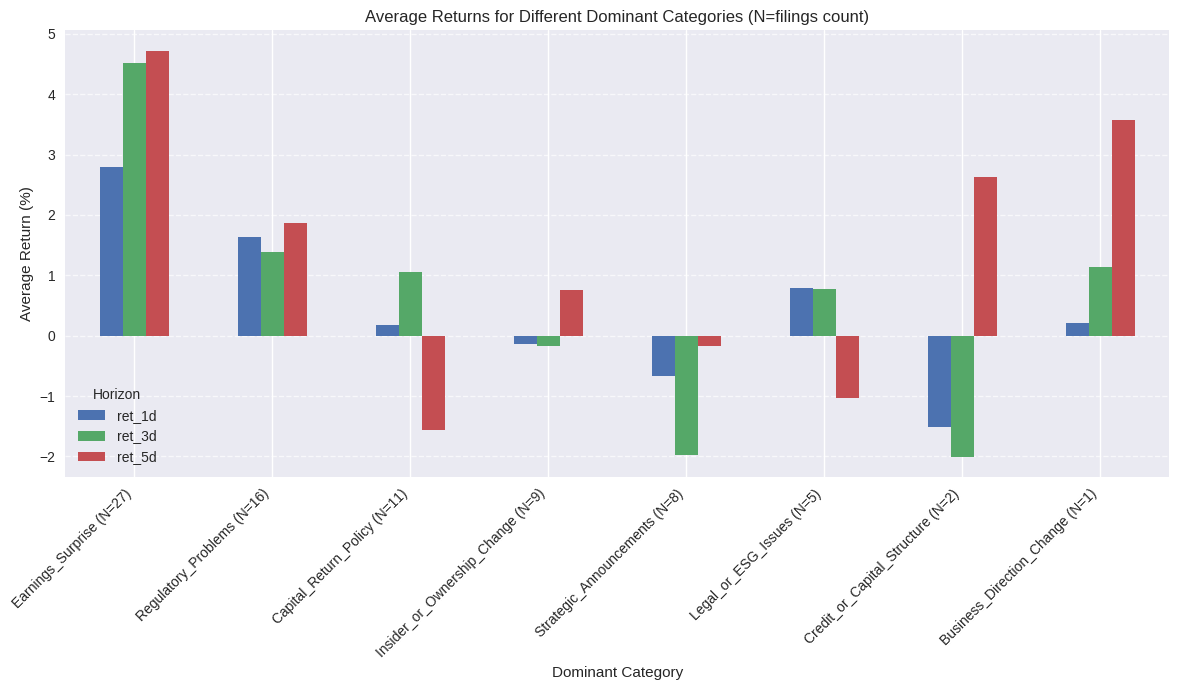

In [ ]:
tab_cat = (
    aligned
    .groupby("dominant_category")
    .agg(
        n=("file_name","count"),
        up_1d=("up_1d","mean"),
        up_3d=("up_3d","mean"),
        up_5d=("up_5d","mean"),
        rev_5d=("reversal_5d","mean"),
        ret_1d=("ret_plus_1d","mean"),
        ret_3d=("ret_plus_3d","mean"),
        ret_5d=("ret_plus_5d","mean"),
        avg_impact=("avg_impact","mean"),
        max_abs_impact=("max_abs_impact","mean")
    )
    .sort_values("n", ascending=False)
)

tab_cat[["up_1d","up_3d","up_5d","rev_5d","ret_1d","ret_3d","ret_5d"]]*=100  # %
tab_cat.head(15)


# Visualization for varying effects of different categories
import matplotlib.pyplot as plt

plot_df = tab_cat[["ret_1d", "ret_3d", "ret_5d"]].copy()
plot_df.index.name = "Category"

plt.figure(figsize=(12, 7))
plot_df.plot(kind="bar", ax=plt.gca())
plt.title("Average Returns for Different Dominant Categories (N=filings count)")
plt.xlabel("Dominant Category")
plt.ylabel("Average Return (%)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Horizon")

# Add N count to x-axis labels
labels = [f"{idx} (N={int(tab_cat.loc[idx, 'n'])})" for idx in tab_cat.index]
plt.gca().set_xticklabels(labels)

plt.tight_layout()
plt.savefig("category_returns.png")
plt.show()

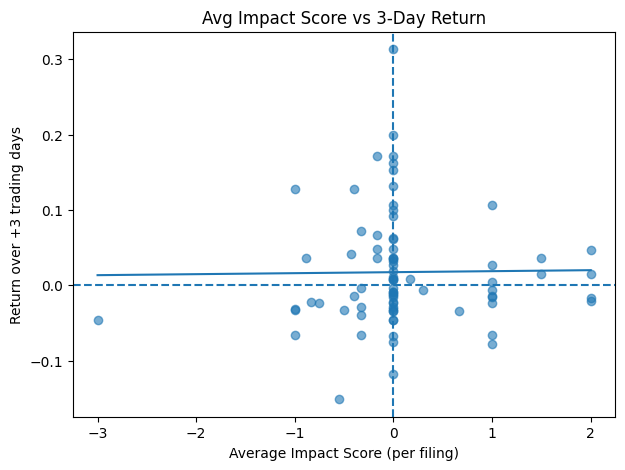

In [ ]:
plt.figure(figsize=(7,5))
x = aligned["avg_impact"]
y = aligned["ret_plus_3d"]
plt.scatter(x, y, alpha=0.6)
# simple OLS line
coef = np.polyfit(x.dropna(), y.dropna(), 1) if x.notna().sum()>1 and y.notna().sum()>1 else [0,0]
xs = np.linspace(x.min(), x.max(), 100)
plt.plot(xs, coef[0]*xs + coef[1])
plt.axhline(0, linestyle="--")
plt.axvline(0, linestyle="--")
plt.title("Avg Impact Score vs 3-Day Return")
plt.xlabel("Average Impact Score (per filing)")
plt.ylabel("Return over +3 trading days")
plt.show()


<Figure size 600x400 with 0 Axes>

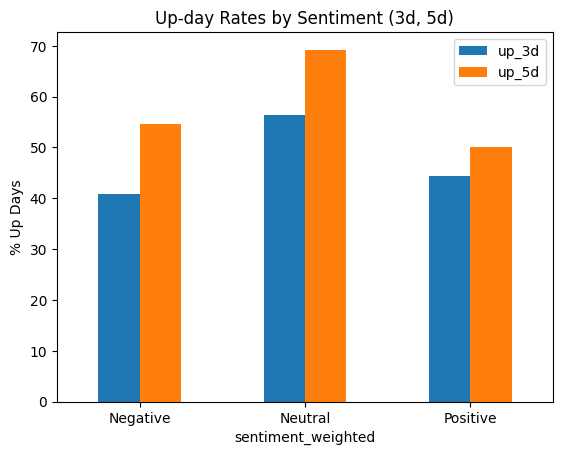

In [ ]:
plot_df = (
    aligned
    .groupby("sentiment_weighted")
    .agg(up_3d=("up_3d","mean"), up_5d=("up_5d","mean"))
    .reindex(["Negative","Neutral","Positive"])
)

plt.figure(figsize=(6,4))
plot_df.mul(100).plot(kind="bar")
plt.title("Up-day Rates by Sentiment (3d, 5d)")
plt.ylabel("% Up Days")
plt.xticks(rotation=0)
plt.legend()
plt.show()


/tmp/ipython-input-135202011.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rev_df = aligned.groupby("impact_bucket")["reversal_5d"].mean().mul(100)


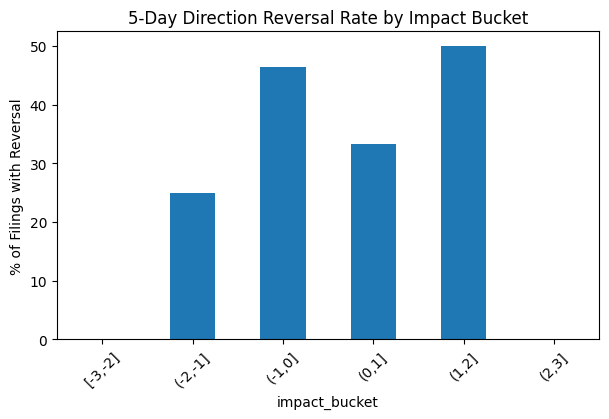

In [ ]:
rev_df = aligned.groupby("impact_bucket")["reversal_5d"].mean().mul(100)
plt.figure(figsize=(7,4))
rev_df.plot(kind="bar")
plt.title("5-Day Direction Reversal Rate by Impact Bucket")
plt.ylabel("% of Filings with Reversal")
plt.xticks(rotation=45)
plt.show()


/tmp/ipython-input-3461986121.py:50: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3461986121.py:56: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  plt.savefig("/content/drive/MyDrive/SEC_DATA/analysis/timeline.png")
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


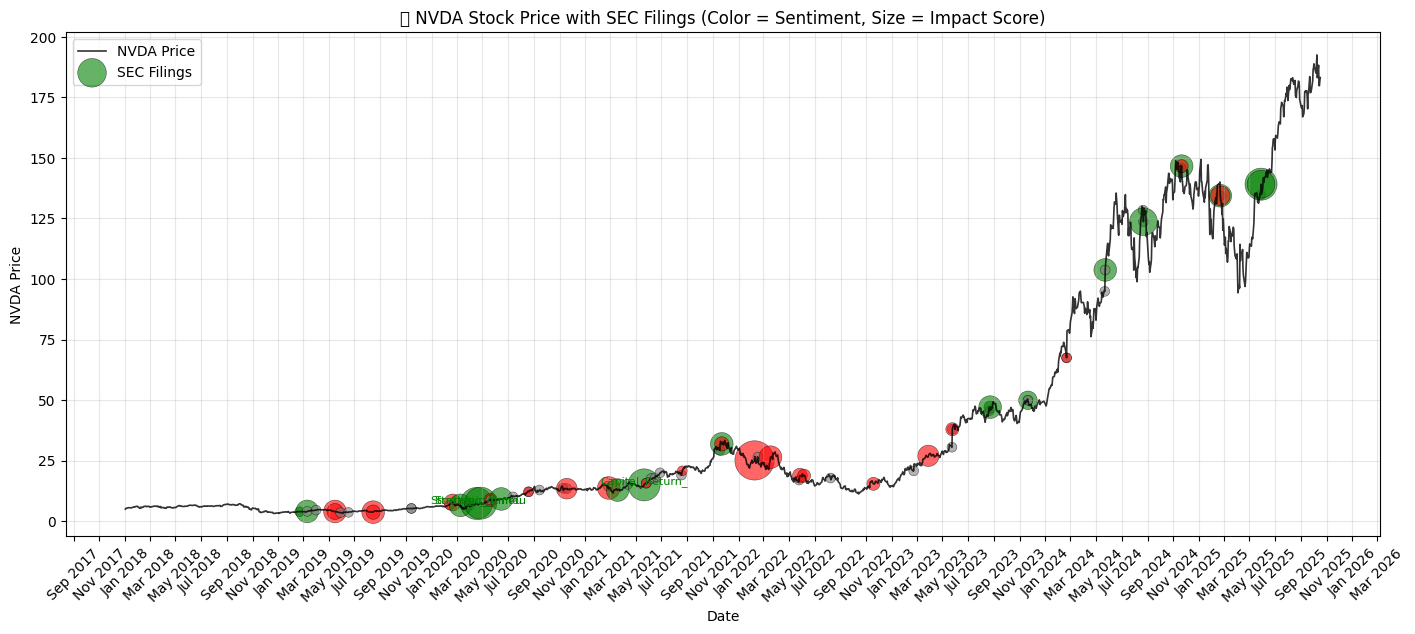

In [ ]:
# ============================================
# 📈 5D. Timeline — Filings over NVDA Price
# ============================================

import matplotlib.dates as mdates

plt.figure(figsize=(14, 6))

# Plot price line
plt.plot(price.index, price["PX"], label="NVDA Price", color="black", linewidth=1.2, alpha=0.8)

# Map sentiment to colors
color_map = {
    "Positive": "green",
    "Neutral": "gray",
    "Negative": "red"
}

# Prepare event data
timeline = aligned.dropna(subset=["event_date", "avg_impact", "sentiment_weighted"])
timeline = timeline.sort_values("event_date")

# Normalize bubble size for visualization
max_size = 800
sizes = (timeline["avg_impact"].abs() / timeline["avg_impact"].abs().max() * max_size).clip(50, max_size)

# Plot bubbles
plt.scatter(
    timeline["event_date"],
    price.reindex(timeline["event_date"])["PX"],
    s=sizes,
    c=timeline["sentiment_weighted"].map(color_map),
    alpha=0.6,
    edgecolor="k",
    linewidth=0.4,
    label="SEC Filing"
)

# Annotate a few notable points (optional)
for i, row in timeline.nlargest(3, "avg_impact").iterrows():
    plt.text(row["event_date"], price.loc[row["event_date"], "PX"] * 1.02,
             f"{row['dominant_category'][:15]}", fontsize=8, ha="center", color=color_map[row["sentiment_weighted"]])

# Formatting
plt.title("📅 NVDA Stock Price with SEC Filings (Color = Sentiment, Size = Impact Score)")
plt.xlabel("Date")
plt.ylabel("NVDA Price")
plt.grid(alpha=0.3)
plt.legend(["NVDA Price", "SEC Filings"])
plt.tight_layout()

# Format x-axis to show months cleanly
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.xticks(rotation=45)
plt.savefig("/content/drive/MyDrive/SEC_DATA/analysis/timeline.png")
plt.show()


In [ ]:
# Load the price data to get the dates
price_df = pd.read_csv("/content/drive/MyDrive/SEC_DATA/price_data.csv", parse_dates=["Date"])

# Get the unique dates from the price data
price_dates = price_df["Date"].unique()

# Convert the filing_date in final_df to datetime objects (if not already)
final_df["filing_date"] = pd.to_datetime(final_df["filing_date"])

# Filter final_df to keep only dates present in price_dates
initial_row_count = len(final_df)
filtered_final_df = final_df[final_df["filing_date"].isin(price_dates)].copy()
rows_dropped = initial_row_count - len(filtered_final_df)

print(f"Number of rows dropped: {rows_dropped}")

# Define the path to save the filtered CSV file
output_csv_path = "/content/drive/MyDrive/SEC_DATA/analysis/final_sentiments_encoded.csv"

# Save the filtered DataFrame to CSV
filtered_final_df.to_csv(output_csv_path, index=False)

print(f"✅ Filtered DataFrame saved to {output_csv_path}")

# Update final_df to the filtered version for subsequent operations
final_df = filtered_final_df

Number of rows dropped: 481
✅ Filtered DataFrame saved to /content/drive/MyDrive/SEC_DATA/analysis/final_sentiments_encoded.csv


In [ ]:
import pandas as pd
from pathlib import Path

# Define the path to the sentiments.csv file
sentiments_path = Path("/content/drive/MyDrive/SEC_DATA/analysis/sentiments.csv")

# Load the sentiments data
sentiments_df = pd.read_csv(sentiments_path, parse_dates=["filing_date"])

# Define the date range
start_date = pd.to_datetime("2021-07-19")
end_date = pd.to_datetime("2025-10-05")

# Filter the DataFrame by the date range
filtered_sentiments = sentiments_df[
    (sentiments_df["filing_date"] >= start_date) &
    (sentiments_df["filing_date"] <= end_date)
].copy()

# Group by filing date and aggregate
# - Calculate the average impact score
# - Collect all categories into a list
aggregated_sentiments = filtered_sentiments.groupby("filing_date").agg(
    avg_impact_score=("impact_score", "mean"),
    categories=("category", lambda x: list(x))
).reset_index()

# Create a date range for all possible dates within the specified range
all_dates = pd.DataFrame(pd.date_range(start=start_date, end=end_date), columns=["filing_date"])

# Merge the aggregated sentiments with the full date range to include dates with no filings
# Use a left merge to keep all dates from all_dates
merged_sentiments = all_dates.merge(aggregated_sentiments, on="filing_date", how="left")

# Fill missing values for dates with no filings
merged_sentiments["avg_impact_score"] = merged_sentiments["avg_impact_score"].fillna(0)
merged_sentiments["categories"] = merged_sentiments["categories"].apply(lambda x: x if isinstance(x, list) else ['None'])

# Select and reorder columns as requested
final_df = merged_sentiments[["filing_date", "avg_impact_score", "categories"]]

# Display the resulting DataFrame
print("✅ Subset of sentiments data:")
display(final_df.head())
display(final_df.tail())

✅ Subset of sentiments data:


,filing_date,avg_impact_score,categories
0,2021-07-19,0.0,[None]
1,2021-07-20,0.0,[None]
2,2021-07-21,0.0,[None]
3,2021-07-22,0.0,[None]
4,2021-07-23,0.0,[None]


,filing_date,avg_impact_score,categories
1535,2025-10-01,0.0,[None]
1536,2025-10-02,0.0,[None]
1537,2025-10-03,0.0,[None]
1538,2025-10-04,0.0,[None]
1539,2025-10-05,0.0,[None]


In [ ]:
pd.DataFrame.to_csv(final_df, '/content/drive/MyDrive/SEC_DATA/analysis/final_sentiments_encoded.csv', index=False)
print("✅ final_df saved to /content/drive/MyDrive/SEC_DATA/analysis/final_sentiments_encoded.csv")

✅ final_df saved to /content/drive/MyDrive/SEC_DATA/analysis/final_sentiments_encoded.csv


# Task
Filter the DataFrame loaded from `/content/drive/MyDrive/SEC_DATA/analysis/final_sentiments_encoded.csv`, converting the 'categories' column to a list and removing rows where 'categories' is `['None']`. Then, sort the filtered DataFrame by 'filing_date' and split it into an 80% training set and a 20% testing set. Finally, print the last 'filing_date' of the training set.

## Filter DataFrame

### Subtask:
Load the CSV, convert the 'categories' column from string representation of a list to an actual list, and then filter out rows where 'categories' is equal to ['None'].


**Reasoning**:
To begin, I will load the specified CSV file into a pandas DataFrame named `final_df`.



In [ ]:
import pandas as pd
import ast

# 1. Load the CSV file
final_df = pd.read_csv('/content/drive/MyDrive/SEC_DATA/analysis/final_sentiments_encoded.csv')


# 3. Filter out rows where 'categories' is equal to ['None']
initial_rows = len(final_df)
final_df = final_df[final_df['categories'] != ['None']].copy()

rows_filtered = initial_rows - len(final_df)
print(f"Number of rows filtered out (where categories was ['None']): {rows_filtered}")

print("\nUpdated DataFrame head after filtering:")
display(final_df.head())
print(f"Updated DataFrame shape: {final_df.shape}")

ValueError: ('Lengths must match to compare', (1540,), (1,))

**Reasoning**:
The previous code failed because direct comparison of a pandas Series containing lists with a single list `['None']` caused a `ValueError` due to mismatched lengths. To fix this, I need to apply a lambda function to compare each list in the 'categories' column with `['None']` individually.



In [ ]:
import pandas as pd
import ast

# 1. Load the CSV file
final_df = pd.read_csv('/content/drive/MyDrive/SEC_DATA/analysis/final_sentiments_encoded.csv')

# 2. Convert the 'categories' column from string representation of a list to an actual list
final_df['categories'] = final_df['categories'].apply(ast.literal_eval)

# 3. Filter out rows where 'categories' is equal to ['None']
initial_rows = len(final_df)
final_df = final_df[final_df['categories'].apply(lambda x: x != ['None'])].copy()

rows_filtered = initial_rows - len(final_df)
print(f"Number of rows filtered out (where categories was ['None']): {rows_filtered}")

print("\nUpdated DataFrame head after filtering:")
display(final_df.head())
print(f"Updated DataFrame shape: {final_df.shape}")

Number of rows filtered out (where categories was ['None']): 1511

Updated DataFrame head after filtering:


,filing_date,avg_impact_score,categories
30,2021-08-18,0.000000,[Earnings_Surprise]
32,2021-08-20,-0.166667,"[Capital_Return_Policy, Earnings_Surprise, Leg..."
121,2021-11-17,0.000000,[Earnings_Surprise]
126,2021-11-22,-0.166667,"[Capital_Return_Policy, Earnings_Surprise, Leg..."
204,2022-02-08,-3.000000,"[Regulatory_Problems, Strategic_Announcements]"


Updated DataFrame shape: (29, 3)


**Reasoning**:
The next step is to sort the filtered DataFrame by 'filing_date' and then split it into an 80% training set and a 20% testing set. Finally, I will print the last 'filing_date' of the training set to complete the subtask.



In [ ]:
import pandas as pd

# 4. Sort the filtered DataFrame by 'filing_date'
final_df['filing_date'] = pd.to_datetime(final_df['filing_date'])
final_df = final_df.sort_values(by='filing_date').reset_index(drop=True)

# 5. Split the DataFrame into an 80% training set and a 20% testing set
train_size = int(0.8 * len(final_df))
train_df = final_df.iloc[:train_size]
test_df = final_df.iloc[train_size:]

print(f"Training set shape: {train_df.shape}")
print(f"Testing set shape: {test_df.shape}")

# 6. Print the last 'filing_date' of the training set
last_filing_date_train = train_df['filing_date'].iloc[-1]
print(f"Last 'filing_date' in the training set: {last_filing_date_train}")

Training set shape: (23, 3)
Testing set shape: (6, 3)
Last 'filing_date' in the training set: 2024-08-21 00:00:00


Files loaded successfully.
Found 29 valid filing events.
Feature Matrix Shape: (29, 14)
Target Matrix Shape: (29, 5)
------------------------------
Model: Sequential Ridge Regressor Chain
MSE: 0.002174
Overall Hit Rate: 40.00%
------------------------------
Hit Rate by Forecast Horizon:
Day 1: 66.67%
Day 2: 33.33%
Day 3: 50.00%
Day 4: 16.67%
Day 5: 33.33%


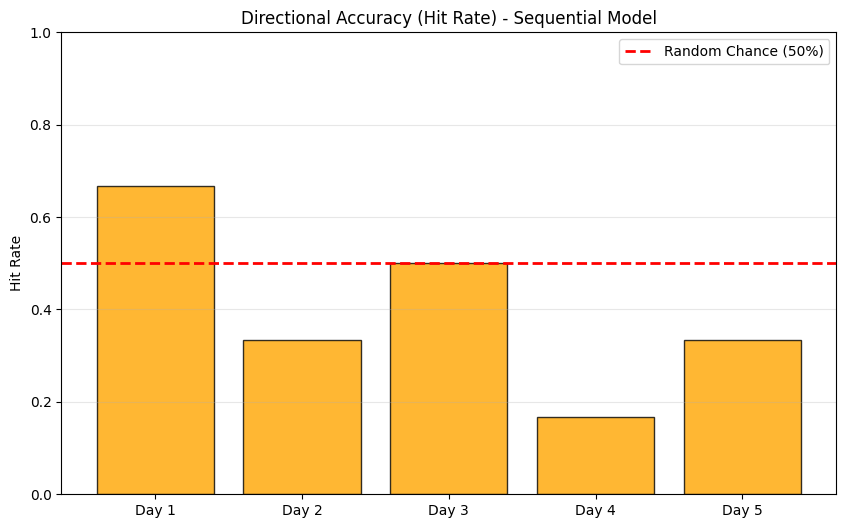

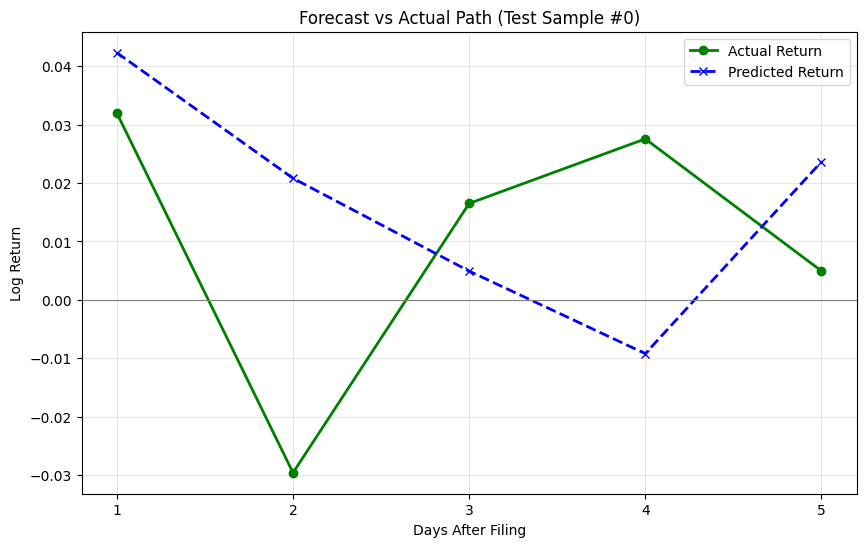

In [ ]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.multioutput import RegressorChain
from sklearn.metrics import mean_squared_error

# ==========================================
# 1. Configuration & Data Loading
# ==========================================
# UPDATE THESE PATHS TO YOUR LOCAL FILES
price_path = '/content/drive/MyDrive/SEC_DATA/price_data.csv'
events_path = '/content/drive/MyDrive/SEC_DATA/analysis/final_sentiments_encoded.csv'

try:
    price_df = pd.read_csv(price_path)
    events_df = pd.read_csv(events_path)
    print("Files loaded successfully.")
except FileNotFoundError:
    print("Error: Files not found. Please check the file paths.")
    # Create dummy data for demonstration if files are missing
    price_df = pd.DataFrame() # ... (dummy logic skipped for brevity)

# ==========================================
# 2. Data Engineering & Preprocessing
# ==========================================

# A. Parse Dates
price_df['Date'] = pd.to_datetime(price_df['Date'])
events_df['filing_date'] = pd.to_datetime(events_df['filing_date'])

# B. Calculate Daily Log Returns
# Sorting ensures correct time-diff calculation
price_df = price_df.sort_values('Date').reset_index(drop=True)
price_df['Log_Ret'] = np.log(price_df['NVDA'] / price_df['NVDA'].shift(1))

# C. Robust Category Parser
def parse_categories_robust(cat_str):
    """
    Robustly parses stringified lists like "['Earnings']" or "['None']".
    Handles malformed strings and standard python lists.
    """
    if pd.isna(cat_str) or cat_str == "['None']":
        return []

    # Method 1: Try standard literal_eval
    try:
        val = ast.literal_eval(cat_str)
        if isinstance(val, list):
            return val
    except:
        pass

    # Method 2: Manual string cleaning
    # Remove brackets and split by comma
    s = cat_str.strip("[]")
    if not s:
        return []

    cleaned_list = []
    for item in s.split(','):
        # Remove quotes and whitespace
        clean_item = item.strip().strip("'").strip('"')
        if clean_item and clean_item != 'None':
            cleaned_list.append(clean_item)

    return cleaned_list

events_df['categories_list'] = events_df['categories'].apply(parse_categories_robust)

# Filter for valid events (those with at least one category)
valid_events = events_df[events_df['categories_list'].apply(len) > 0].copy()
print(f"Found {len(valid_events)} valid filing events.")

# ==========================================
# 3. Construct Feature (X) and Target (Y) Matrices
# ==========================================
X_past_returns = []
Y_future_returns = []
valid_indices = []

# Convert price dates to numpy array for fast search
price_dates_np = price_df['Date'].values

for idx, row in valid_events.iterrows():
    f_date = row['filing_date']

    # Find the index of the filing date in the price data
    # (or the next available trading day)
    try:
        price_idx = np.searchsorted(price_dates_np, f_date)
    except TypeError:
        price_idx = np.searchsorted(price_dates_np, np.datetime64(f_date))

    # Check bounds: We need 5 days BEFORE and 5 days AFTER
    if price_idx < 5 or price_idx > len(price_df) - 6:
        continue

    # Input: Past 5 Days Returns
    past_rets = price_df.iloc[price_idx-5:price_idx]['Log_Ret'].values

    # Target: Next 5 Days Returns
    future_rets = price_df.iloc[price_idx+1:price_idx+6]['Log_Ret'].values

    # Validate data (ensure shape is correct and no NaNs)
    if len(past_rets) == 5 and len(future_rets) == 5:
        if not (np.isnan(past_rets).any() or np.isnan(future_rets).any()):
            X_past_returns.append(past_rets)
            Y_future_returns.append(future_rets)
            valid_indices.append(idx)

# D. Encode Categorical Features
mlb = MultiLabelBinarizer()
final_events = valid_events.loc[valid_indices]
cat_encoded = mlb.fit_transform(final_events['categories_list'])
impact_scores = final_events['avg_impact_score'].values.reshape(-1, 1)

# E. Combine all features into X
# X structure: [Past_Returns (5) | Categories (N) | Impact_Score (1)]
X = np.hstack([np.array(X_past_returns), cat_encoded, impact_scores])
Y = np.array(Y_future_returns)

print(f"Feature Matrix Shape: {X.shape}")
print(f"Target Matrix Shape: {Y.shape}")

# ==========================================
# 4. Sequential Modeling (Regressor Chain)
# ==========================================
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialize Base Estimator (Ridge)
base_model = Ridge(alpha=1.0)

# Initialize Chain: Predicts y1 -> y2 (using y1) -> y3 (using y1, y2)...
# order=None implies the natural order [0, 1, 2, 3, 4]
chain_model = RegressorChain(base_model, order=None, random_state=42)

# Train
chain_model.fit(X_train, Y_train)

# Predict
predictions = chain_model.predict(X_test)

# ==========================================
# 5. Evaluation & Metrics
# ==========================================
mse = mean_squared_error(Y_test, predictions)

# Hit Rate: Percentage of correct direction signs
hit_matrix = (np.sign(predictions) == np.sign(Y_test))
hit_rate_overall = np.mean(hit_matrix)
hit_rate_daily = np.mean(hit_matrix, axis=0)

print("-" * 30)
print(f"Model: Sequential Ridge Regressor Chain")
print(f"MSE: {mse:.6f}")
print(f"Overall Hit Rate: {hit_rate_overall:.2%}")
print("-" * 30)
print("Hit Rate by Forecast Horizon:")
for day, rate in enumerate(hit_rate_daily, 1):
    print(f"Day {day}: {rate:.2%}")

# ==========================================
# 6. Plotting Results
# ==========================================

# Plot 1: Hit Rate by Day
plt.figure(figsize=(10, 6))
days_labels = ['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5']
plt.bar(days_labels, hit_rate_daily, color='orange', edgecolor='black', alpha=0.8)
plt.axhline(0.5, color='red', linestyle='--', linewidth=2, label='Random Chance (50%)')
plt.title('Directional Accuracy (Hit Rate) - Sequential Model')
plt.ylabel('Hit Rate')
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

# Plot 2: Example Forecast Path
# Visualize the first sample in the test set
sample_idx = 0
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), Y_test[sample_idx], marker='o', label='Actual Return', color='green', linewidth=2)
plt.plot(range(1, 6), predictions[sample_idx], marker='x', linestyle='--', label='Predicted Return', color='blue', linewidth=2)
plt.title(f'Forecast vs Actual Path (Test Sample #{sample_idx})')
plt.xlabel('Days After Filing')
plt.ylabel('Log Return')
plt.xticks(range(1, 6))
plt.axhline(0, color='gray', linewidth=0.8)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Assuming 'Y_test' (Actual) and 'preds' (Predicted) are available from the previous step

# 1. Calculate MSE
mse = mean_squared_error(Y_test, predictions)

# 2. Calculate Hit Rate (Directional Accuracy)
# Returns True if signs match, False otherwise
hit_matrix = (np.sign(predictions) == np.sign(Y_test))

# Average over all predictions (flattened)
hit_rate_overall = np.mean(hit_matrix)

# Average per day (column-wise)
hit_rate_daily = np.mean(hit_matrix, axis=0)

print(f"MSE: {mse:.6f}")
print(f"Overall Hit Rate: {hit_rate_overall:.2%}")
print(f"Hit Rate by Day: {hit_rate_daily}")

MSE: 0.002174
Overall Hit Rate: 40.00%
Hit Rate by Day: [0.66666667 0.33333333 0.5        0.16666667 0.33333333]


In [ ]:
from sklearn.multioutput import RegressorChain
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

# ... (Assume X and Y are prepared as before) ...

# Split Data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# --- Define Sequential Model ---
# RegressorChain automatically passes predictions from t to t+1
# 'order=None' defaults to 0 -> 1 -> 2 -> 3 -> 4
base_estimator = Ridge(alpha=1.0)
chain_model = RegressorChain(base_estimator, order=None, random_state=42)

# Train
chain_model.fit(X_train, Y_train)

# Predict
# The model internally predicts Day 1, feeds it to Day 2, etc.
predictions_sequential = chain_model.predict(X_test)

# Evaluate
print("Predictions for Test Set (Sequential):")
print(predictions_sequential)

Predictions for Test Set (Sequential):
[[ 0.04232271  0.02082137  0.00492138 -0.00920545  0.02364695]
 [ 0.04136071  0.02014553  0.00463932 -0.00927119  0.02368342]
 [ 0.04359315  0.02101217  0.00564787 -0.01034007  0.02372782]
 [ 0.04376254  0.02124923  0.00538527 -0.00908946  0.02363622]
 [ 0.0314926   0.00770349 -0.01591196  0.03274119 -0.00023005]
 [ 0.03672677  0.00951099 -0.02670986  0.02774758  0.02804217]]
